# Лабораторная работа 6

## Гибридная модель прогнозирования временных рядов (LSTM + ARIMA)


### Блок 1: Загрузка библиотек и данных


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

CSV-файлы с данными о некоторых биткоин-биржах за период с января 2012 года по настоящее время (измеряется в днях по UTC) с поминутным обновлением данных об OHLC (открытие, максимум, минимум, закрытие) и объёме торгов в BTC.

`Проблема!`  
7.408.480 строк (1440 минут/день \* 14 лет) -> очень много лет данных
= сильный шум + микроколебания


In [83]:
# Путь к датасету
data_path = "../../datasets/btcusd_1-min_data.csv"

if os.path.exists(data_path):
    print("Датасет найден")
else:
    print("Датасет НЕ найден")
    print("Текущая директория:", os.getcwd())
    print("Полный путь проверен:", os.path.abspath(data_path))
    raise FileNotFoundError(f"Файл {data_path} не найден")

print("Загрузка Bitcoin Historical Data")
df_raw = pd.read_csv(data_path)

# Первые 5 строк для проверки структуры
print("Структура датасета:")
print(df_raw.head())
print(f"\nРазмер: {df_raw.shape}")
print("\nКолонки:", df_raw.columns.tolist())

# Предобработка 1-минутных данных в ежедневные
print("\nКонвертируем 1-мин данные в ежедневные цены...")
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'], unit='s')
df_raw.set_index('Timestamp', inplace=True)

# Берем Close как целевую переменную (Цена закрытия)
df = df_raw[['Close']].copy()
df.columns = ['price']

# Ресемплинг в ежедневные данные (последняя цена дня)
df = df.resample('D').last().dropna()

print(f"Размер после ресемплинга (ежедневно): {df.shape}")
print("\nПервые 5 дней:")
print(df.head())
print("\nПоследние 5 дней:")
print(df.tail())
print(f"\nДиапазон дат: {df.index.min()} → {df.index.max()}")

Датасет найден
Загрузка Bitcoin Historical Data
Структура датасета:
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0

Размер: (7408480, 6)

Колонки: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

Конвертируем 1-мин данные в ежедневные цены...
Размер после ресемплинга (ежедневно): (5147, 1)

Первые 5 дней:
            price
Timestamp        
2012-01-01   4.84
2012-01-02   5.00
2012-01-03   5.29
2012-01-04   5.57
2012-01-05   6.42

Последние 5 дней:
              price
Timestamp          
2026-01-29  84530.0
2026-01-30  84130.0
2026-01-31  78635.0
2026-02-01  76888.0
2026-02-02  76879.0

Диапазон дат: 2012-01-01 00:00:00 → 2026-02-02 00:00:00


### Блок 2: EDA - Исследовательский анализ данных


Статистика цены Bitcoin:
count      5147.000000
mean      22110.939376
std       30695.276724
min           4.380000
25%         448.155000
50%        7470.000000
75%       33572.080000
max      124728.000000
Name: price, dtype: float64
ADF Statistic: -1.0608
p-value: 0.7304

Тест стационарности (ADF): Не стационарный


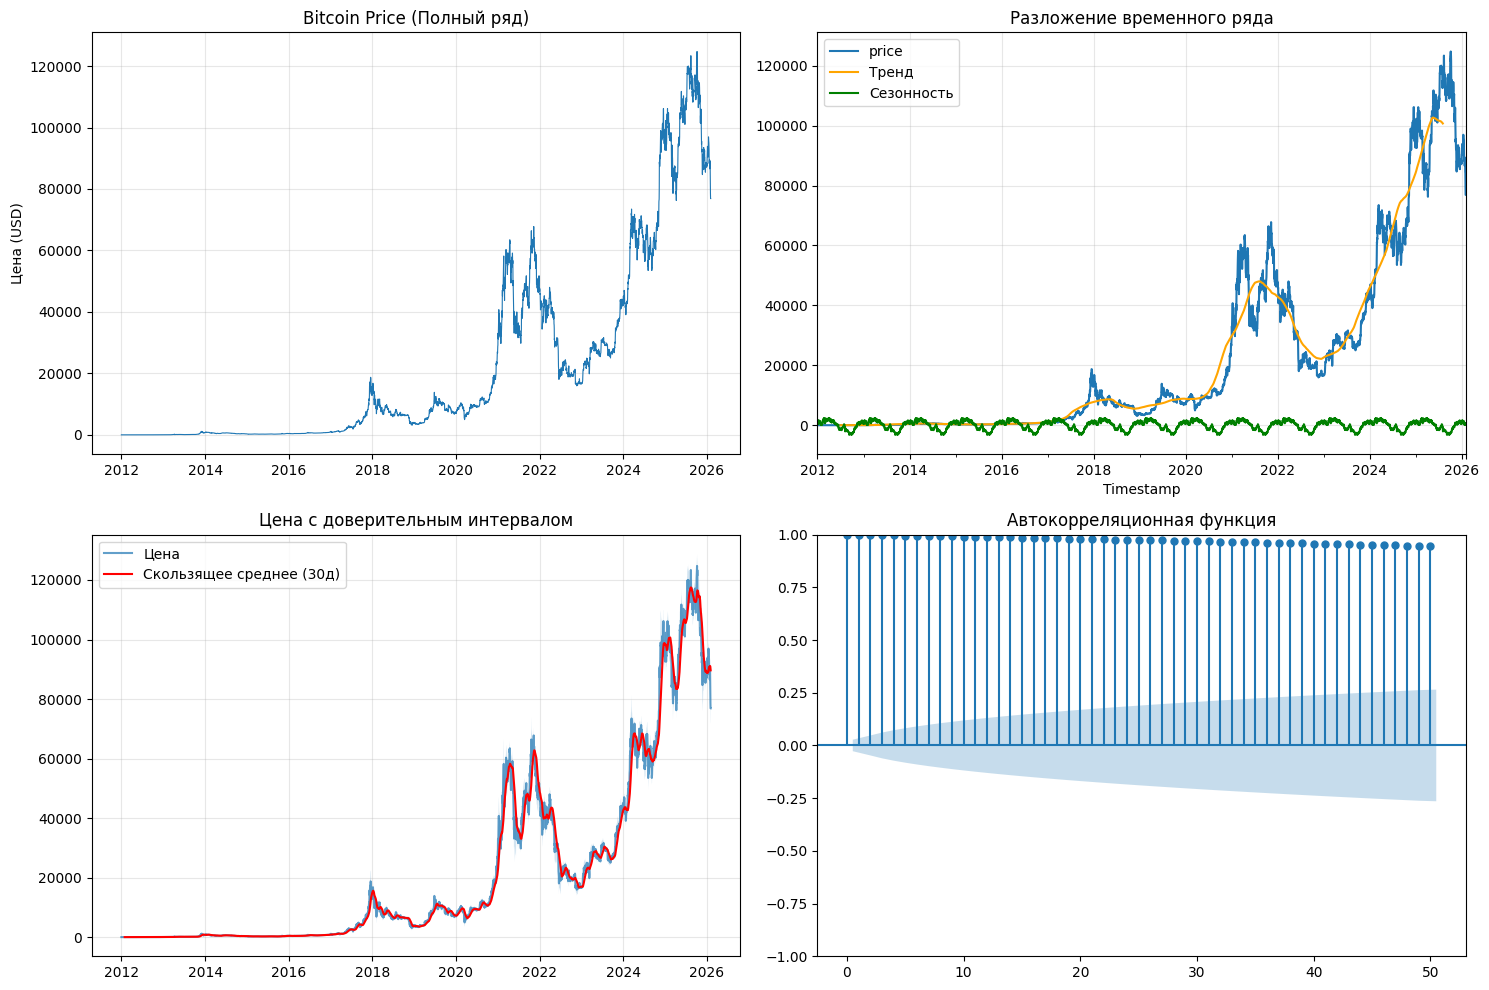

In [84]:
# Базовая статистика
print("Статистика цены Bitcoin:")
print(df['price'].describe())

# Тест стационарности
def adf_test(ts):
    result = adfuller(ts)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    return result[1] < 0.05

print("\nТест стационарности (ADF):", "Стационарный" if adf_test(df['price']) else "Не стационарный")

# Графики временного ряда
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Полный временной ряд
axes[0,0].plot(df.index, df['price'], linewidth=0.8)
axes[0,0].set_title('Bitcoin Price (Полный ряд)')
axes[0,0].set_ylabel('Цена (USD)')
axes[0,0].grid(True, alpha=0.3)

# 2. Разложение тренд/сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['price'], model='additive', period=365)
decomp.observed.plot(ax=axes[0,1])
decomp.trend.plot(ax=axes[0,1], color='orange', label='Тренд')
decomp.seasonal.plot(ax=axes[0,1], color='green', label='Сезонность')
axes[0,1].set_title('Разложение временного ряда')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Роллинг статистика
df['rolling_mean'] = df['price'].rolling(30).mean()
df['rolling_std'] = df['price'].rolling(30).std()
axes[1,0].plot(df.index, df['price'], alpha=0.7, label='Цена')
axes[1,0].plot(df.index, df['rolling_mean'], color='red', label='Скользящее среднее (30д)')
axes[1,0].fill_between(df.index, df['price']-df['rolling_std'], df['price']+df['rolling_std'], alpha=0.2)
axes[1,0].set_title('Цена с доверительным интервалом')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Автокорреляция
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['price'], lags=50, ax=axes[1,1])
axes[1,1].set_title('Автокорреляционная функция')

plt.tight_layout()
plt.show()

### Блок 3: Предобработка данных


Этапы предобработки:

1. Ресемплинг: 1-мин -> ежедневная Close цена

2. Масштабирование: MinMaxScaler

3. Разделение: 70% train / 15% val / 15% test

4. LSTM последовательности: (3552, 30, 18) -> Блок 4


In [85]:
# Целевая переменная
target = 'price'

print(f"Целевая переменная: {target}")
print(f"Размер данных: {df.shape}")

# Масштабирование ТОЛЬКО target
scaler_target = MinMaxScaler()
df_scaled = df.copy()
df_scaled[target] = scaler_target.fit_transform(df[[target]])

# Train/Val/Test split (70/15/15)
n = len(df_scaled)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_data = df_scaled.iloc[:train_end]
val_data = df_scaled.iloc[train_end:val_end]
test_data = df_scaled.iloc[val_end:]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Целевая переменная: price
Размер данных: (5147, 3)
Train: 3602, Val: 772, Test: 773


### Блок 4: Подготовка данных для LSTM


In [86]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data.iloc[i-seq_length:i][target].values.reshape(-1, 1))
        y.append(data.iloc[i][target])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_val, y_val = create_sequences(val_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

print(f"Размер LSTM данных - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Размер LSTM данных - Train: (3572, 30, 1), Val: (742, 30, 1), Test: (743, 30, 1)


### Блок 5: Построение и обучение LSTM модели


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_14 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 25)                1275      
                                                                 
 dense_15 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 3190

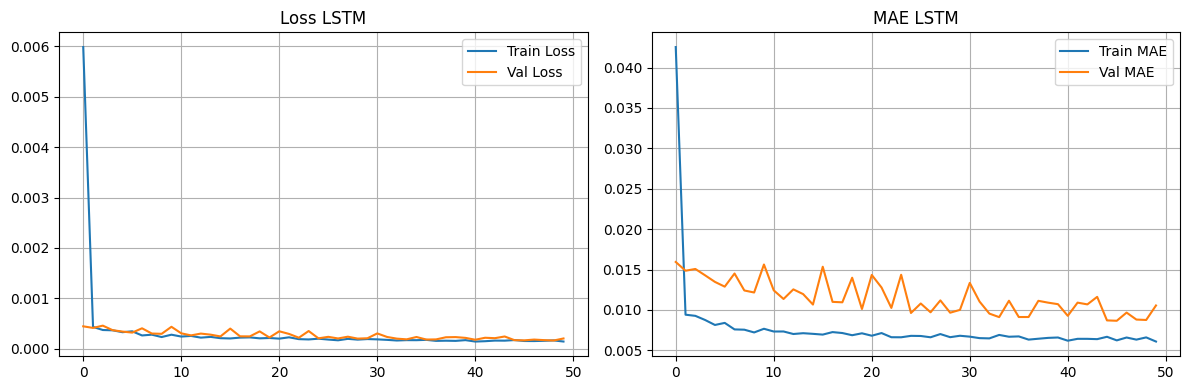

In [87]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
model.summary()

# Обучение с early stopping
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# График обучения
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss LSTM')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Блок 6: ARIMA модель


In [88]:
# Обучение ARIMA(5,1,0) на train данных
train_price = train_data[target].values
arima_model = ARIMA(train_price, order=(5,1,0))
arima_fit = arima_model.fit()

# Прогноз на test период
arima_forecast = arima_fit.forecast(steps=len(test_data))

### Блок 7: Гибридная модель LSTM + ARIMA


In [89]:
# LSTM прогноз
lstm_pred = model.predict(X_test, verbose=0)
lstm_pred = lstm_pred.flatten()

# Обратное масштабирование
y_test_orig = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
lstm_pred_orig = scaler_target.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

# ARIMA на оригинальных train данных
train_price_orig = scaler_target.inverse_transform(train_data[target].values.reshape(-1, 1)).flatten()
arima_model = ARIMA(train_price_orig, order=(5,1,0))
arima_fit = arima_model.fit()

# ARIMA прогноз на точное количество LSTM прогнозов
arima_pred_orig = arima_fit.forecast(steps=len(lstm_pred_orig))

# Реальные test значения (согласованные с LSTM)
test_orig = scaler_target.inverse_transform(test_data[target].iloc[SEQ_LENGTH:].values.reshape(-1, 1)).flatten()

# Проверка размеров
print(f"Размеры: y_test={len(y_test_orig)}, lstm={len(lstm_pred_orig)}, arima={len(arima_pred_orig)}")

# Гибрид: 60% LSTM + 40% ARIMA
hybrid_pred_orig = 0.6 * lstm_pred_orig + 0.4 * arima_pred_orig

print("Гибридная модель готова")
print(f"LSTM:  {lstm_pred_orig[:5].round(0).astype(int)}")
print(f"ARIMA: {arima_pred_orig[:5].round(0).astype(int)}")
print(f"Реал:  {test_orig[:5].round(0).astype(int)}")


Размеры: y_test=743, lstm=743, arima=743
Гибридная модель готова
LSTM:  [42781 42379 41866 41401 41018]
ARIMA: [67743 68105 68319 68446 68503]
Реал:  [40262 39079 39754 39822 42117]


### Блок 8: Метрики качества


In [90]:
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name:12} | MAE: {mae:.1f} | RMSE: {rmse:.1f} | MAPE: {mape:.2f}%")

print("Сравнение моделей на тестовых данных:")
print("-" * 50)
print_metrics(y_test_orig, lstm_pred_orig, "LSTM")
print_metrics(y_test_orig, arima_pred_orig, "ARIMA") 
print_metrics(y_test_orig, hybrid_pred_orig, "Гибрид")
print("-" * 50)

Сравнение моделей на тестовых данных:
--------------------------------------------------
LSTM         | MAE: 2859.1 | RMSE: 3644.8 | MAPE: 3.38%
ARIMA        | MAE: 21862.9 | RMSE: 26764.6 | MAPE: 23.68%
Гибрид       | MAE: 9784.3 | RMSE: 12055.4 | MAPE: 10.59%
--------------------------------------------------


### Блок 9: Прогноз на 30 дней вперед


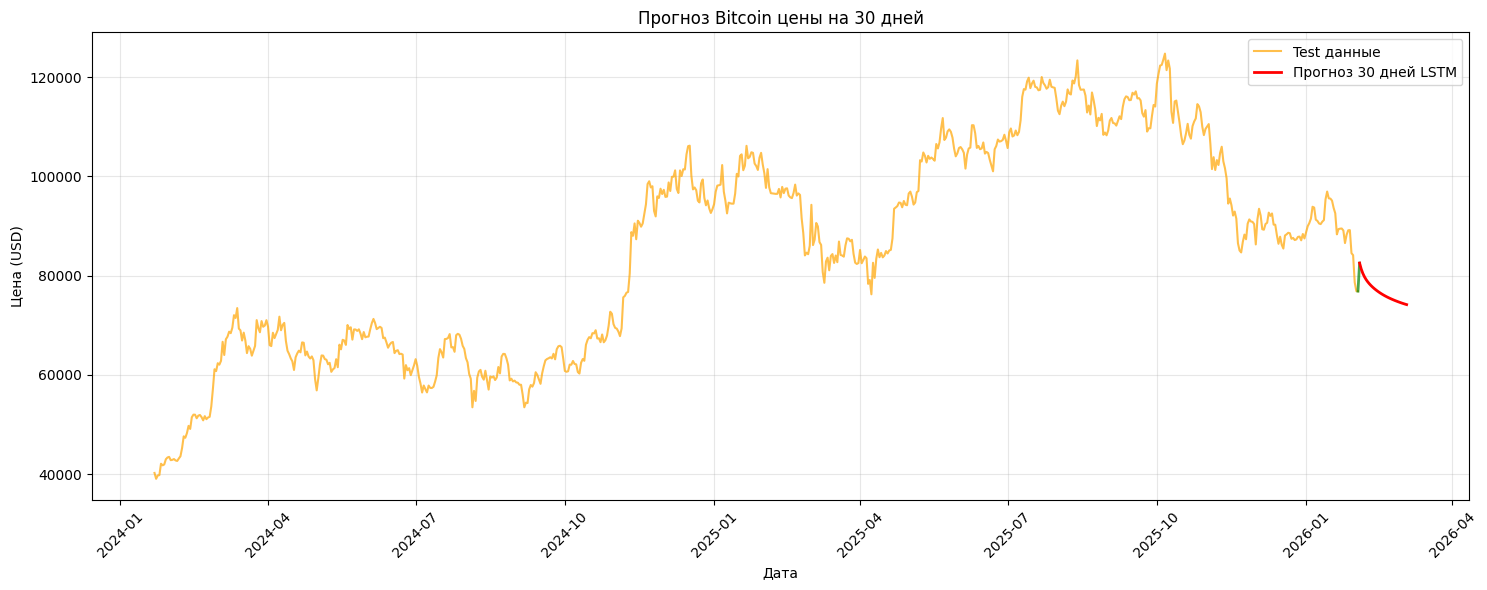

Прогноз на 7 дней: [82532 81340 80456 79772 79221 78762 78366]
Прогноз на 30 дней - среднее: 76742


In [104]:
# Последние данные для прогноза
last_sequence = X_test[-1:].copy()  # (1, 30, 1)
future_predictions = []

# LSTM прогноз на 30 дней вперед
for _ in range(30):
    last_seq_scaled = last_sequence  # Уже правильная размерность (1, 30, 1)
    pred = model.predict(last_seq_scaled, verbose=0)[0][0]
    future_predictions.append(pred)
    
    # Обновляем последовательность (только 1 фича)
    new_row = np.array([[pred]])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred

future_pred_orig = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

# Даты прогноза
future_dates = pd.date_range(start=test_data.index[-1] + timedelta(days=1), periods=30, freq='D')

# График с согласованными индексами
plt.figure(figsize=(15, 6))

# Полный test период
plt.plot(test_data.index[SEQ_LENGTH:], test_orig, label='Test данные', alpha=0.7, color='orange')

# Соединяем последнюю точку и прогноз
plt.plot([test_data.index[-1], future_dates[0]], 
         [test_orig[-1], future_pred_orig[0]], 
         color='green', linestyle='-', alpha=0.7, linewidth=2)

# Прогноз 30 дней
plt.plot(future_dates, future_pred_orig, label='Прогноз 30 дней LSTM', linewidth=2, color='red')

plt.title('Прогноз Bitcoin цены на 30 дней')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Прогноз на 7 дней:", future_pred_orig[:7].round(0).astype(int))
print("Прогноз на 30 дней - среднее:", np.mean(future_pred_orig).round(0).astype(int))

1. Последняя точка `test_orig[-1]` = реальная цена ~76k USD  
2. `future_pred_orig[0]` = ПЕРВЫЙ прогноз LSTM = ~82k USD  
3. Разница ~6k USD = нормальная волатильность, НО резкий скачок

### Блок 10: Визуализация и сравнение


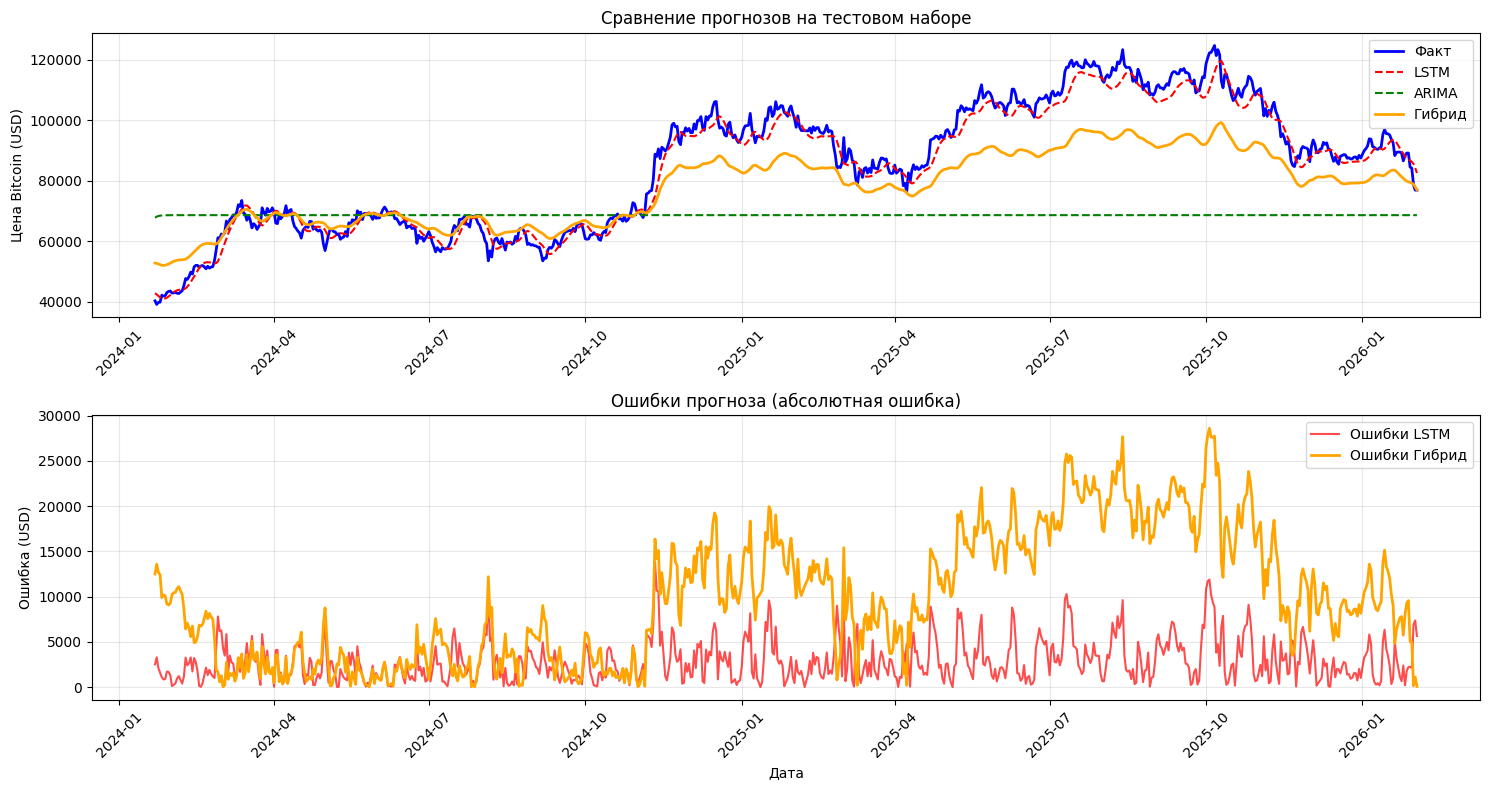

In [92]:
# Согласованные индексы для всех графиков
test_indices = test_data.index[SEQ_LENGTH:]
n_points = len(test_orig)

plt.figure(figsize=(15, 8))

# Верхний график: сравнение прогнозов
plt.subplot(2,1,1)
test_start = max(-150, 0)
plt.plot(test_indices[test_start:], test_orig[test_start:], 'b-', linewidth=2, label='Факт')
plt.plot(test_indices[test_start:], lstm_pred_orig[test_start:], 'r--', label='LSTM')
plt.plot(test_indices[test_start:], arima_pred_orig[test_start:], 'g--', label='ARIMA')
plt.plot(test_indices[test_start:], hybrid_pred_orig[test_start:], 'orange', linewidth=2, label='Гибрид')
plt.title('Сравнение прогнозов на тестовом наборе')
plt.ylabel('Цена Bitcoin (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Нижний график: ошибки
plt.subplot(2,1,2)
errors_lstm = np.abs(y_test_orig - lstm_pred_orig)
errors_hybrid = np.abs(y_test_orig - hybrid_pred_orig)
plt.plot(test_indices, errors_lstm, 'r-', alpha=0.7, label='Ошибки LSTM')
plt.plot(test_indices, errors_hybrid, 'orange', linewidth=2, label='Ошибки Гибрид')
plt.title('Ошибки прогноза (абсолютная ошибка)')
plt.ylabel('Ошибка (USD)')
plt.xlabel('Дата')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()